## Requirement 1: Stochatic Environment
Pricing algorithm: Build a pricing strategy using the continuous set of prices p ∈ [0, 1] and Gaussian Processes.\
**Bidding algorithm: Consider a sequence of second-price auctions. Build two learning algorithms to deal with the bidding problem:**
- primal-dual algorithm for truthful auctions
- UCB-like algorithm

### Import

In [2]:
import numpy as np
import matplotlib.pyplot as plt

### Second price auctions

In [3]:
class SecondPriceAuction:
    def __init__(self, ctrs):
        # ctr = click though rate = lambda * q
        self.ctrs = ctrs
        self.n_adv = len(self.ctrs)
    
    def get_winners(self, bids):
        # sort not by bids, but estimated values
        adv_values = self.ctrs*bids
        adv_ranking = np.argsort(adv_values)
        winner = adv_ranking[-1]
        return winner, adv_values
    
    def get_payments_per_click(self, winners, values, bids):
        adv_ranking = np.argsort(values)
        second = adv_ranking[-2]
        payment = values[second]/self.ctrs[winners]
        return payment.round(2)
    
    def round(self, bids):
        # given bids, return winner(s) and the estimated values (product of 3 terms : lambda, q, bid) of winner(s)
        winners, values = self.get_winners(bids) # allocation mechanism!
        payments_per_click = self.get_payments_per_click(winners, values, bids)
        return winners, payments_per_click

### Bidding Agents

#### Primal-dual algorithm -> Multiplicative Pacing

In [4]:
class MultiplicativePacingAgent:
    def __init__(self, valuation, budget, T, eta):
        self.valuation = valuation
        self.budget = budget
        self.eta = eta # learning rate
        self.T = T
        self.rho = self.budget/self.T
        self.lmbd = 1  # shouldn't this be initialized with 0?
        self.t = 0

    def bid(self):
        if self.budget < 1:
            return 0
        return self.valuation/(self.lmbd+1)
    
    def update(self, f_t, c_t):
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t), 
                            a_min=0, a_max=1/self.rho)
        self.budget -= c_t

# EXP3.P

#### UCB-like algorithm -> UCB-Multiplicative Pacing

In [5]:
class UCBMultiPaceAgent:
    def __init__(self, valuation, budget, T, eta, number_rhos, range=1):
        self.valuation = valuation
        self.budget = budget
        self.eta = eta # learning rate
        self.T = T
        self.range = range
        self.used_rho = None
        self.number_rhos = number_rhos
        self.average_rewards = np.zeros(number_rhos)
        self.N_pulls = np.zeros(number_rhos)
        self.rhos = np.linspace(budget/T, valuation, number_rhos)
        self.lmbds = np.ones(number_rhos)
        self.t = 0

    def bid(self):
        # play every arm once
        if self.t < self.number_rhos:
            self.used_rho = self.t 
        else:
            # compute UCB for every arms, choose arm with highest UCB
            ucbs = self.average_rewards + self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)
            self.used_rho = np.argmax(ucbs)
    
        if self.budget < 1:
            return 0
        return self.valuation/(self.lmbds[self.used_rho]+1)
    
    def update(self, f_t, c_t):
        self.N_pulls[self.used_rho] += 1
        # update only used rho's average reward
        self.average_rewards[self.used_rho] += (f_t - self.average_rewards[self.used_rho])/self.N_pulls[self.used_rho]
        # update all rhos's lmbd according to c_t and their rho value
        self.lmbds = np.clip(self.lmbds-self.eta*(self.rhos-c_t), 
                            a_min=0, a_max=1/self.rhos)
        self.budget -= c_t
        self.t += 1

#### UCB-like algorithm -> simple UCB

In [62]:
class UCBAgent:
    def __init__(self, valuation, budget, T, K=100, range=1):
        self.T = T
        self.valuation = valuation
        self.budget = budget
        self.K = K
        self.range = range
        self.arms = np.linspace(0, valuation, K)
        self.average_rewards = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.a_t = None
        self.t = 0

    def bid(self):
        # if budget depleted
        if self.budget < 1:
            return 0
        
        # play every arm at least once
        if self.t < self.K:
            self.a_t = self.t
        else:
            # compute UCB for every arms, choose arm with highest UCB
            ucbs = self.average_rewards + self.range*np.sqrt(2*np.log(self.t)/self.N_pulls)
            self.a_t = np.argmax(ucbs)
            if(self.t<50):
                print(f'round {self.t} : {ucbs}\n bidded {self.arms[self.a_t]} with ucb={ucbs[self.a_t]}')
        return self.arms[self.a_t]

    def update(self, f_t, c_t):
        self.t += 1
        self.N_pulls[self.a_t] += 1
        self.average_rewards[self.a_t] += (f_t - self.average_rewards[self.a_t])/self.N_pulls[self.a_t]
        self.budget -= c_t

#### UCB-like algorithm -> Full Feedback UCB with negative feedback when not winning (lost opportunity)
FF = knowing maximum bids of each round -> m_t

In [51]:
class FFUCBAgent:
    def __init__(self, valuation, budget, T, m_t, K=100, range=1):
        self.T = T
        self.valuation = valuation
        self.budget = budget
        self.m_t = m_t
        self.K = K
        self.range = range
        self.arms = np.linspace(0, valuation, K)
        self.average_rewards = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.a_t = None
        self.t = 0

    def bid(self):
        # if budget depleted
        if self.budget < 1:
            return 0
        
        # play every arm at least once
        if self.t < self.K:
            self.a_t = self.t
        else:
            # compute UCB for every arms, choose arm with highest UCB
            ucbs = self.average_rewards + self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)
            self.a_t = np.argmax(ucbs)
            if(self.t<50):
                print(f'round {self.t} : {ucbs}\n bidded {self.arms[self.a_t]} with ucb={ucbs[self.a_t]}')
        return self.arms[self.a_t]

    def update(self, f_t, c_t):
        self.N_pulls[self.a_t] += 1
        # TODO as we have full feedback, we shall update all average_rewards instead of only pulled arm
        # if lost, negative feedback = -(utility if agent bid higher and won)
        if(self.arms[self.a_t] < self.m_t[self.t]):
            f_t = - (self.valuation - self.m_t[self.t]) # 
    
        self.average_rewards[self.a_t] += (f_t - self.average_rewards[self.a_t])/self.N_pulls[self.a_t]
        self.budget -= c_t
        self.t += 1

#### UCB-like algorithm -> UCB with negative feedback when not winning (lost opportunity)
lost opportunity computed as average utility when winning

In [59]:
class UCBNFAgent:
    def __init__(self, valuation, budget, T, K=100, range=1):
        self.T = T
        self.valuation = valuation
        self.budget = budget
        self.K = K
        self.range = range
        self.arms = np.linspace(0, valuation, K)
        self.average_rewards = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.winning_total_reward = 0
        self.won_time = 0
        self.a_t = None
        self.t = 0

    def bid(self):
        # if budget depleted
        if self.budget < 1:
            return 0
        
        # play every arm at least once
        if self.t < self.K:
            self.a_t = self.t
        else:
            # compute UCB for every arms, choose arm with highest UCB
            ucbs = self.average_rewards + self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)
            self.a_t = np.argmax(ucbs)
            if(self.t<50):
                print(f'round {self.t} : {ucbs}\n bidded {self.arms[self.a_t]} with ucb={ucbs[self.a_t]}')
        return self.arms[self.a_t]

    def update(self, f_t, c_t):
        self.N_pulls[self.a_t] += 1
        
        if(f_t>0):
            self.won_time += 1
            self.winning_total_reward += f_t
        elif(self.t >= self.K):
            f_t = - (self.winning_total_reward / self.won_time)
    
        self.average_rewards[self.a_t] += (f_t - self.average_rewards[self.a_t])/self.N_pulls[self.a_t]
        self.budget -= c_t
        self.t += 1

#### Clairvoyant agent

In [7]:
### As a re-usable function:
def get_clairvoyant_truthful(B, my_valuation, m_t, n_users):
    ## I compute my sequence of utilities at every round
    utility = (my_valuation-m_t)*(my_valuation>=m_t)
    #   if valuation less than max_bid of the round, no need to participate
    #   if higher, utility is the difference

    ## Now I have to find the sequence of m_t summing up to budget B and having the maximum sum of utility
    ## In second price auctions, I can find the sequence **greedily**:
    sorted_round_utility = np.flip(np.argsort(utility)) # sorted rounds, from most profitable to less profitable
    clairvoyant_utilities = np.zeros(n_users)
    clairvoyant_bids= np.zeros(n_users)
    clairvoyant_payments = np.zeros(n_users)
    c = 0
    i = 0
    #    (enough budget) and (examined all rounds)
    while c <= B-1 and i < n_users:
        clairvoyant_bids[sorted_round_utility[i]] = 1  # simply bid 1 because we are in second-price auction
        clairvoyant_utilities[sorted_round_utility[i]] = utility[sorted_round_utility[i]]
        clairvoyant_payments[sorted_round_utility[i]] = m_t[sorted_round_utility[i]]
        c += m_t[sorted_round_utility[i]]  # cost is incremented by second price of that round
        i+=1
    return clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments

### Simulation

In [79]:
# environmental settings
n_users = 10000

# advertisers' fixed parameters
n_advertisers = 4 # four advertisers, including myself -> 3 competitors
ctrs = np.ones(n_advertisers)
other_bids = np.random.uniform(0, 1, size = (n_advertisers-1, n_users))
m_t = other_bids.max(axis=0)
## advertisers free to exceed my budget

my_valuation = 0.8
B = 5000
clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments = get_clairvoyant_truthful(B, my_valuation, m_t, n_users)


# eta = 1/np.sqrt(n_users) # from theory
# agent = MultiplicativePacingAgent(valuation=my_valuation,
#                                   budget=B,
#                                   T=n_users, 
#                                   eta=eta)

# agent = UCBAgent(my_valuation, B, n_users, K=int(100), range=1)
agent = UCBNFAgent(my_valuation, B, n_users, K=int(10), range=0.5)


auction = SecondPriceAuction(ctrs)

utilities = np.array([])
my_bids = np.array([])
my_payments = np.array([])
total_wins = 0

np.random.seed(18)
for u in range(n_users):
    # interaction
    my_bid = agent.bid()
    bids = np.append(my_bid, other_bids[:, u].ravel())
    winners, payments_per_click = auction.round(bids=bids)
    my_win = int(winners==0)
    f_t, c_t = (my_valuation-m_t[u])*my_win, m_t[u]*my_win
    agent.update(f_t, c_t)
    # logging
    if(u<50):
        print(f'winning bid : {m_t[u]}\n')
    utilities = np.append(utilities, f_t)
    my_bids = np.append(my_bids, my_bid)
    my_payments = np.append(my_payments, c_t)
    total_wins+=my_win
print(f'Total # of Wins: {total_wins}')

winning bid : 0.6503742417395917

winning bid : 0.5054533737348429

winning bid : 0.8786014709215519

winning bid : 0.6503232145878883

winning bid : 0.8522330686745971

winning bid : 0.7501362861060107

winning bid : 0.6661016674853226

winning bid : 0.9878954482759622

winning bid : 0.8695285205556366

winning bid : 0.6990952449893147

round 10 : [2.14596603 2.14596603 2.14596603 2.14596603 2.14596603 2.14596603
 2.14596603 2.14596603 2.14596603 2.24687078]
 bidded 0.8 with ucb=2.2468707813000326
winning bid : 0.9276407771063174

round 11 : [2.14596603 2.14596603 2.14596603 2.14596603 2.14596603 2.14596603
 2.14596603 2.14596603 2.14596603 1.51742713]
 bidded 0.0 with ucb=2.145966026289347
winning bid : 0.9799384637950758

round 12 : [1.46697475 2.14596603 2.14596603 2.14596603 2.14596603 2.14596603
 2.14596603 2.14596603 2.14596603 1.51742713]
 bidded 0.08888888888888889 with ucb=2.145966026289347
winning bid : 0.7361746251160107

round 13 : [1.46697475 1.46697475 2.14596603 2.14596

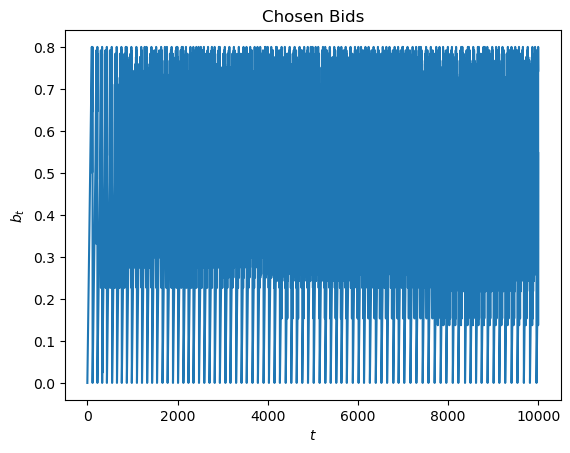

In [77]:
plt.plot(my_bids)
plt.xlabel('$t$')
plt.ylabel('$b_t$')
plt.title('Chosen Bids')
plt.show()

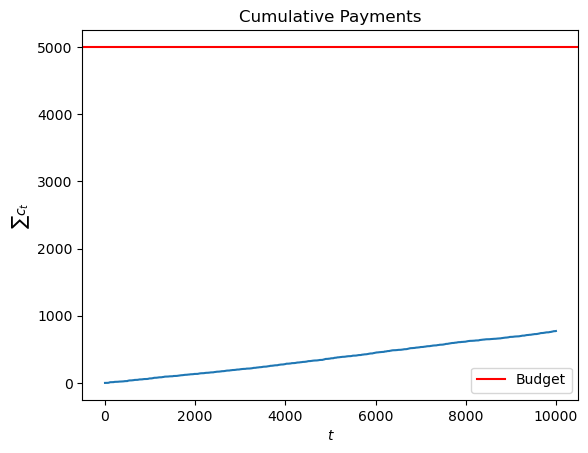

In [78]:
cumulative_payments = np.cumsum(my_payments)
plt.plot(cumulative_payments)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments')
plt.show()

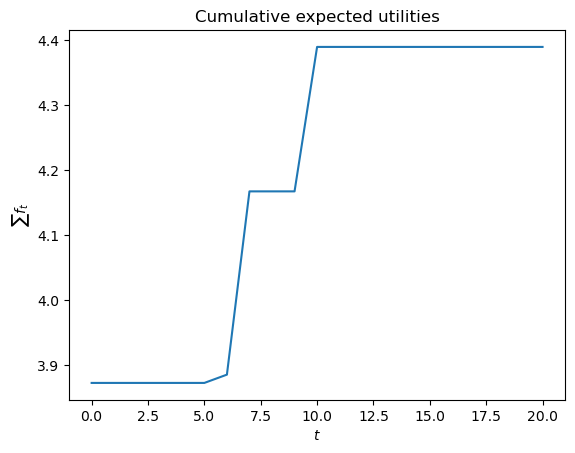

In [31]:
cumulative_expected_utilities = np.cumsum(utilities)
plt.plot(cumulative_expected_utilities[79:100])
plt.xlabel('$t$')
plt.ylabel('$\sum f_t$')
plt.title('Cumulative expected utilities')
plt.show()

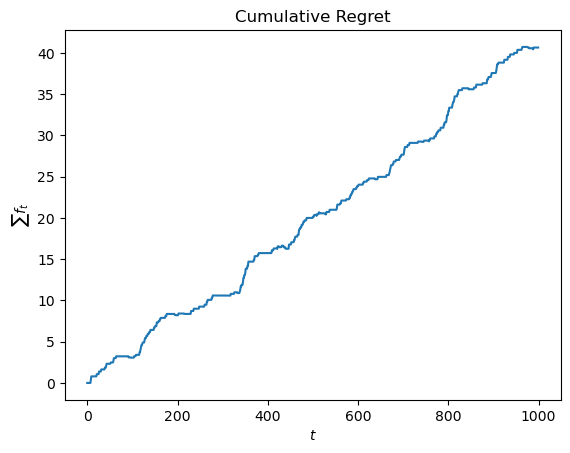

In [19]:
cumulative_regret = np.cumsum(clairvoyant_utilities-utilities)
plt.plot(cumulative_regret)
plt.xlabel('$t$')
plt.ylabel('$\sum f_t$')
plt.title('Cumulative Regret')
plt.show()